In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Библиотеки

In [3]:
pip install catboost

     |████████████████████████████████| 76.4 MB 24 kB/s 


In [52]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.formula.api as sf

import scipy.stats as stats
import pylab 


from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

from keras import models
from keras import layers 
from sklearn.datasets import make_regression

from sklearn import preprocessing
from sklearn.preprocessing import normalize


### Дополнительное

In [5]:
# сводная таблица
def pivot(df):
    extra = pd.DataFrame()
    extra['unique'] = df.nunique() # кол-во уникальных значений
    extra['null'] = df.isnull().sum() # кол-во нулевых значений
    extra['types'] = df.dtypes # тип колонки
    return extra.sort_values('unique')

In [6]:
# функция для выборки одного признака из двух коррелируемых
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

In [7]:
# заменяем нулевые
def my_fillna(df, feature, numb, gr_feat='city'):

    grp = df.groupby([gr_feat]) # группировка

    df[feature] = grp[feature].apply(lambda x: x.fillna(x.median())) # заменим на медианное значение 

    if df[feature].isnull().sum() > 0:
        df[feature] = df[feature].fillna(numb)
    return df[feature].isnull().sum()

In [8]:
# frequency encoding 
def freq_enc(feature, df):
    enc = df[feature].value_counts(normalize=True)
    df['FE_{}'.format(feature)] = df[feature].map(enc)

In [46]:
# пайплайн модели catboost
def cb_pipeline(x, y, cat_cols):

    X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=0)  

    cbr = CatBoostRegressor(cat_features=cat_cols)
    cbr.fit(X_train, y_train)

    # на график остатков
    y_train_pred = cbr.predict(X_train)
    y_valid_pred = (cbr.predict(X_valid))*0.8
    plt.figure(figsize=(10, 5))
    plt.scatter(y_train_pred, y_train_pred-y_train, c='steelblue', marker='o', edgecolor='white', label='Обучающие данные')
    plt.scatter(y_valid_pred, y_valid_pred-y_valid, c='limegreen', marker='s', edgecolor='white', label='Испытательные данные')
    plt.xlabel('Спрогнозированные значения')
    plt.ylabel('Остатки')
    plt.legend(loc='lower left')
    plt.hlines(y=0, xmin=4000, xmax=60000, color='black', lw=2)
    None

    print('MSE при обучении: %.3f, при испытании %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_valid, y_valid_pred)))

    return cbr

### Подготовка данных

In [10]:
df = pd.read_csv('/content/drive/MyDrive/data/train.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [12]:
df.head()

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,osm_catering_points_in_0.0075,osm_catering_points_in_0.01,osm_city_closest_dist,osm_city_nearest_name,osm_city_nearest_population,osm_crossing_closest_dist,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01,osm_culture_points_in_0.001,osm_culture_points_in_0.005,osm_culture_points_in_0.0075,osm_culture_points_in_0.01,osm_finance_points_in_0.001,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.005,osm_hotels_points_in_0.0075,osm_hotels_points_in_0.01,osm_leisure_points_in_0.005,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01,osm_offices_points_in_0.001,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01,osm_subway_closest_dist,osm_train_stop_closest_dist,osm_train_stop_points_in_0.005,osm_train_stop_points_in_0.0075,osm_train_stop_points_in_0.01,osm_transport_stop_closest_dist,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01,per_square_meter_price,reform_count_of_houses_1000,reform_count_of_houses_500,reform_house_population_1000,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,Пермь,NaN,COL_0,57.998207,56.292797,4,19,35,52,0,0,0,0,0,2,4,6,3.293470,Пермь,1055397.0,0.027732,3,6,17,34,0,0,1,1,0,0,1,2,2,3,4,0,0,1,0,0,0,0,1,2,0,1,2,4,4,11,20,28,269.024986,3.368385,0,0,0,0.002864,4,13,21,139937.500000,136,49,2503.0,765.0,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.0,S27289,2020-01-05,10,0
1,Шатура,NaN,COL_1,55.574284,39.543835,3,24,37,59,0,0,0,1,0,2,2,6,43.950989,Орехово-Зуево,120184.0,0.089441,0,31,50,57,0,1,2,3,0,0,1,2,1,1,3,2,4,6,2,2,2,1,1,2,0,1,2,3,1,12,20,29,102.455451,1.476600,0,0,0,0.154661,4,10,11,60410.714286,146,37,1336.0,514.0,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.0,S17052,2020-01-05,10,0
2,Ярославль,NaN,COL_2,57.619140,39.850525,1,30,67,128,0,0,1,1,0,3,6,11,2.676293,Ярославль,603961.0,0.200995,0,15,29,53,0,1,2,2,0,0,5,9,0,1,3,0,0,0,0,0,1,2,3,6,0,1,6,9,1,16,37,80,243.361937,1.455127,0,0,0,0.118275,9,13,21,45164.761264,105,27,1883.0,573.0,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.4,S16913,2020-01-05,110,0
3,Новокузнецк,NaN,COL_3,53.897083,87.108604,0,0,5,21,0,0,0,1,0,0,1,4,15.618563,Новокузнецк,552105.0,0.861400,0,0,0,5,0,0,0,0,0,0,0,1,0,0,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,4,11,295.633502,9.400855,0,0,0,1.036523,0,0,3,28805.263158,75,2,1801.0,54.0,8.581081,9.000000,1992.716216,2014.000000,Кемеровская область,190.0,S10148,2020-01-05,110,0
4,Москва,NaN,COL_4,55.802590,37.487110,1,23,64,153,0,1,1,1,0,8,14,26,9.995325,Химки,232066.0,0.236744,0,14,40,78,0,0,0,0,0,0,3,9,2,7,14,0,2,2,1,1,3,3,4,9,0,8,8,12,0,8,33,89,1.110429,1.235503,0,0,0,0.235032,10,32,62,13222.591362,144,38,3090.0,619.0,7.263889,5.684211,1963.229167,1960.500000,Москва,60.2,S1338,2020-01-05,10,0


In [13]:
# описательная статистика
df.describe()

,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,osm_catering_points_in_0.0075,osm_catering_points_in_0.01,osm_city_closest_dist,osm_city_nearest_population,osm_crossing_closest_dist,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01,osm_culture_points_in_0.001,osm_culture_points_in_0.005,osm_culture_points_in_0.0075,osm_culture_points_in_0.01,osm_finance_points_in_0.001,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.005,osm_hotels_points_in_0.0075,osm_hotels_points_in_0.01,osm_leisure_points_in_0.005,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01,osm_offices_points_in_0.001,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01,osm_subway_closest_dist,osm_train_stop_closest_dist,osm_train_stop_points_in_0.005,osm_train_stop_points_in_0.0075,osm_train_stop_points_in_0.01,osm_transport_stop_closest_dist,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01,per_square_meter_price,reform_count_of_houses_1000,reform_count_of_houses_500,reform_house_population_1000,reform_house_population_500,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,total_square,realty_type,price_type
count,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,2.797370e+05,279792.000000,279792.000000,279792.000000,279792.000000,279792.00000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,279792.000000,2.797920e+05,279792.000000,279792.000000,265196.000000,252558.000000,263084.000000,249624.000000,263553.000000,250155.000000,279792.000000,279792.000000,279792.000000
mean,54.364078,47.763540,2.709084,40.605146,81.596171,133.285458,0.037442,0.885701,2.046467,3.748163,0.614414,8.810970,17.408561,28.341454,15.516565,2.584430e+06,0.519421,0.737344,14.097683,29.307475,48.71462,0.071857,1.487837,3.258067,5.555917,0.145883,2.050423,4.041327,6.442375,2.030673,4.152703,6.836268,1.681188,3.679873,6.225678,1.042767,2.143657,3.555641,2.022713,4.188147,7.047953,0.239188,3.109102,6.216915,10.217090,1.620772,22.637438,44.802353,72.466940,170.930940,9.604875,0.078637,0.196360,0.347601,0.575846,6.262863,12.951189,21.618520,1.101955e+05,100.453691,30.110661,2042.541716,644.610557,7.051233,7.360464,1967.532599,1967.988580,507.833604,54.974088,0.016058
std,4.245713,17.044625,4.202451,53.293388,105.193169,172.290136,0.391014,6.858338,14.801566,25.679859,1.695269,17.713251,33.267316,53.790038,34.755675,4.110835e+06,4.011926,1.386548,15.136481,30.232170,49.24749,0.372920,4.407199,8.815882,13.994591,0.457838,3.371304,6.111080,9.351825,3.331527,6.429165,10.338075,3.908801,7.823028,12.736713,3.312283,6.422509,10.342464,3.042804,5.686815,9.094224,0.737926,5.517670,10.720621,17.458145,2.65

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279792 entries, 0 to 279791
Data columns (total 77 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   city                                 279792 non-null  object 
 1   floor                                103555 non-null  object 
 2   id                                   279792 non-null  object 
 3   lat                                  279792 non-null  float64
 4   lng                                  279792 non-null  float64
 5   osm_amenity_points_in_0.001          279792 non-null  int64  
 6   osm_amenity_points_in_0.005          279792 non-null  int64  
 7   osm_amenity_points_in_0.0075         279792 non-null  int64  
 8   osm_amenity_points_in_0.01           279792 non-null  int64  
 9   osm_building_points_in_0.001         279792 non-null  int64  
 10  osm_building_points_in_0.005         279792 non-null  int64  
 11  osm_building_

In [15]:
# Преобразую время
df['date'] = pd.to_datetime(df['date'])

In [16]:
df['date'] = df['date'].astype(np.int64) // 10 ** 9

In [17]:
# свобдная таблица
def pivot(df):
    extra = pd.DataFrame()
    extra['unique'] = df.nunique() # кол-во уникальных значений
    extra['null'] = df.isnull().sum() # кол-во нулевых значений
    extra['types'] = df.dtypes # тип колонки
    return extra.sort_values('unique')

In [18]:
pivot(df)

,unique,null,types
price_type,2,0,int64
realty_type,3,0,int64
osm_finance_points_in_0.001,7,0,int64
osm_offices_points_in_0.001,13,0,int64
osm_culture_points_in_0.001,16,0,int64
osm_crossing_points_in_0.001,17,0,int64
osm_train_stop_points_in_0.005,19,0,int64
osm_train_stop_points_in_0.0075,24,0,int64
osm_catering_points_in_0.001,24,0,int64
osm_building_points_in_0.001,25,0,int64


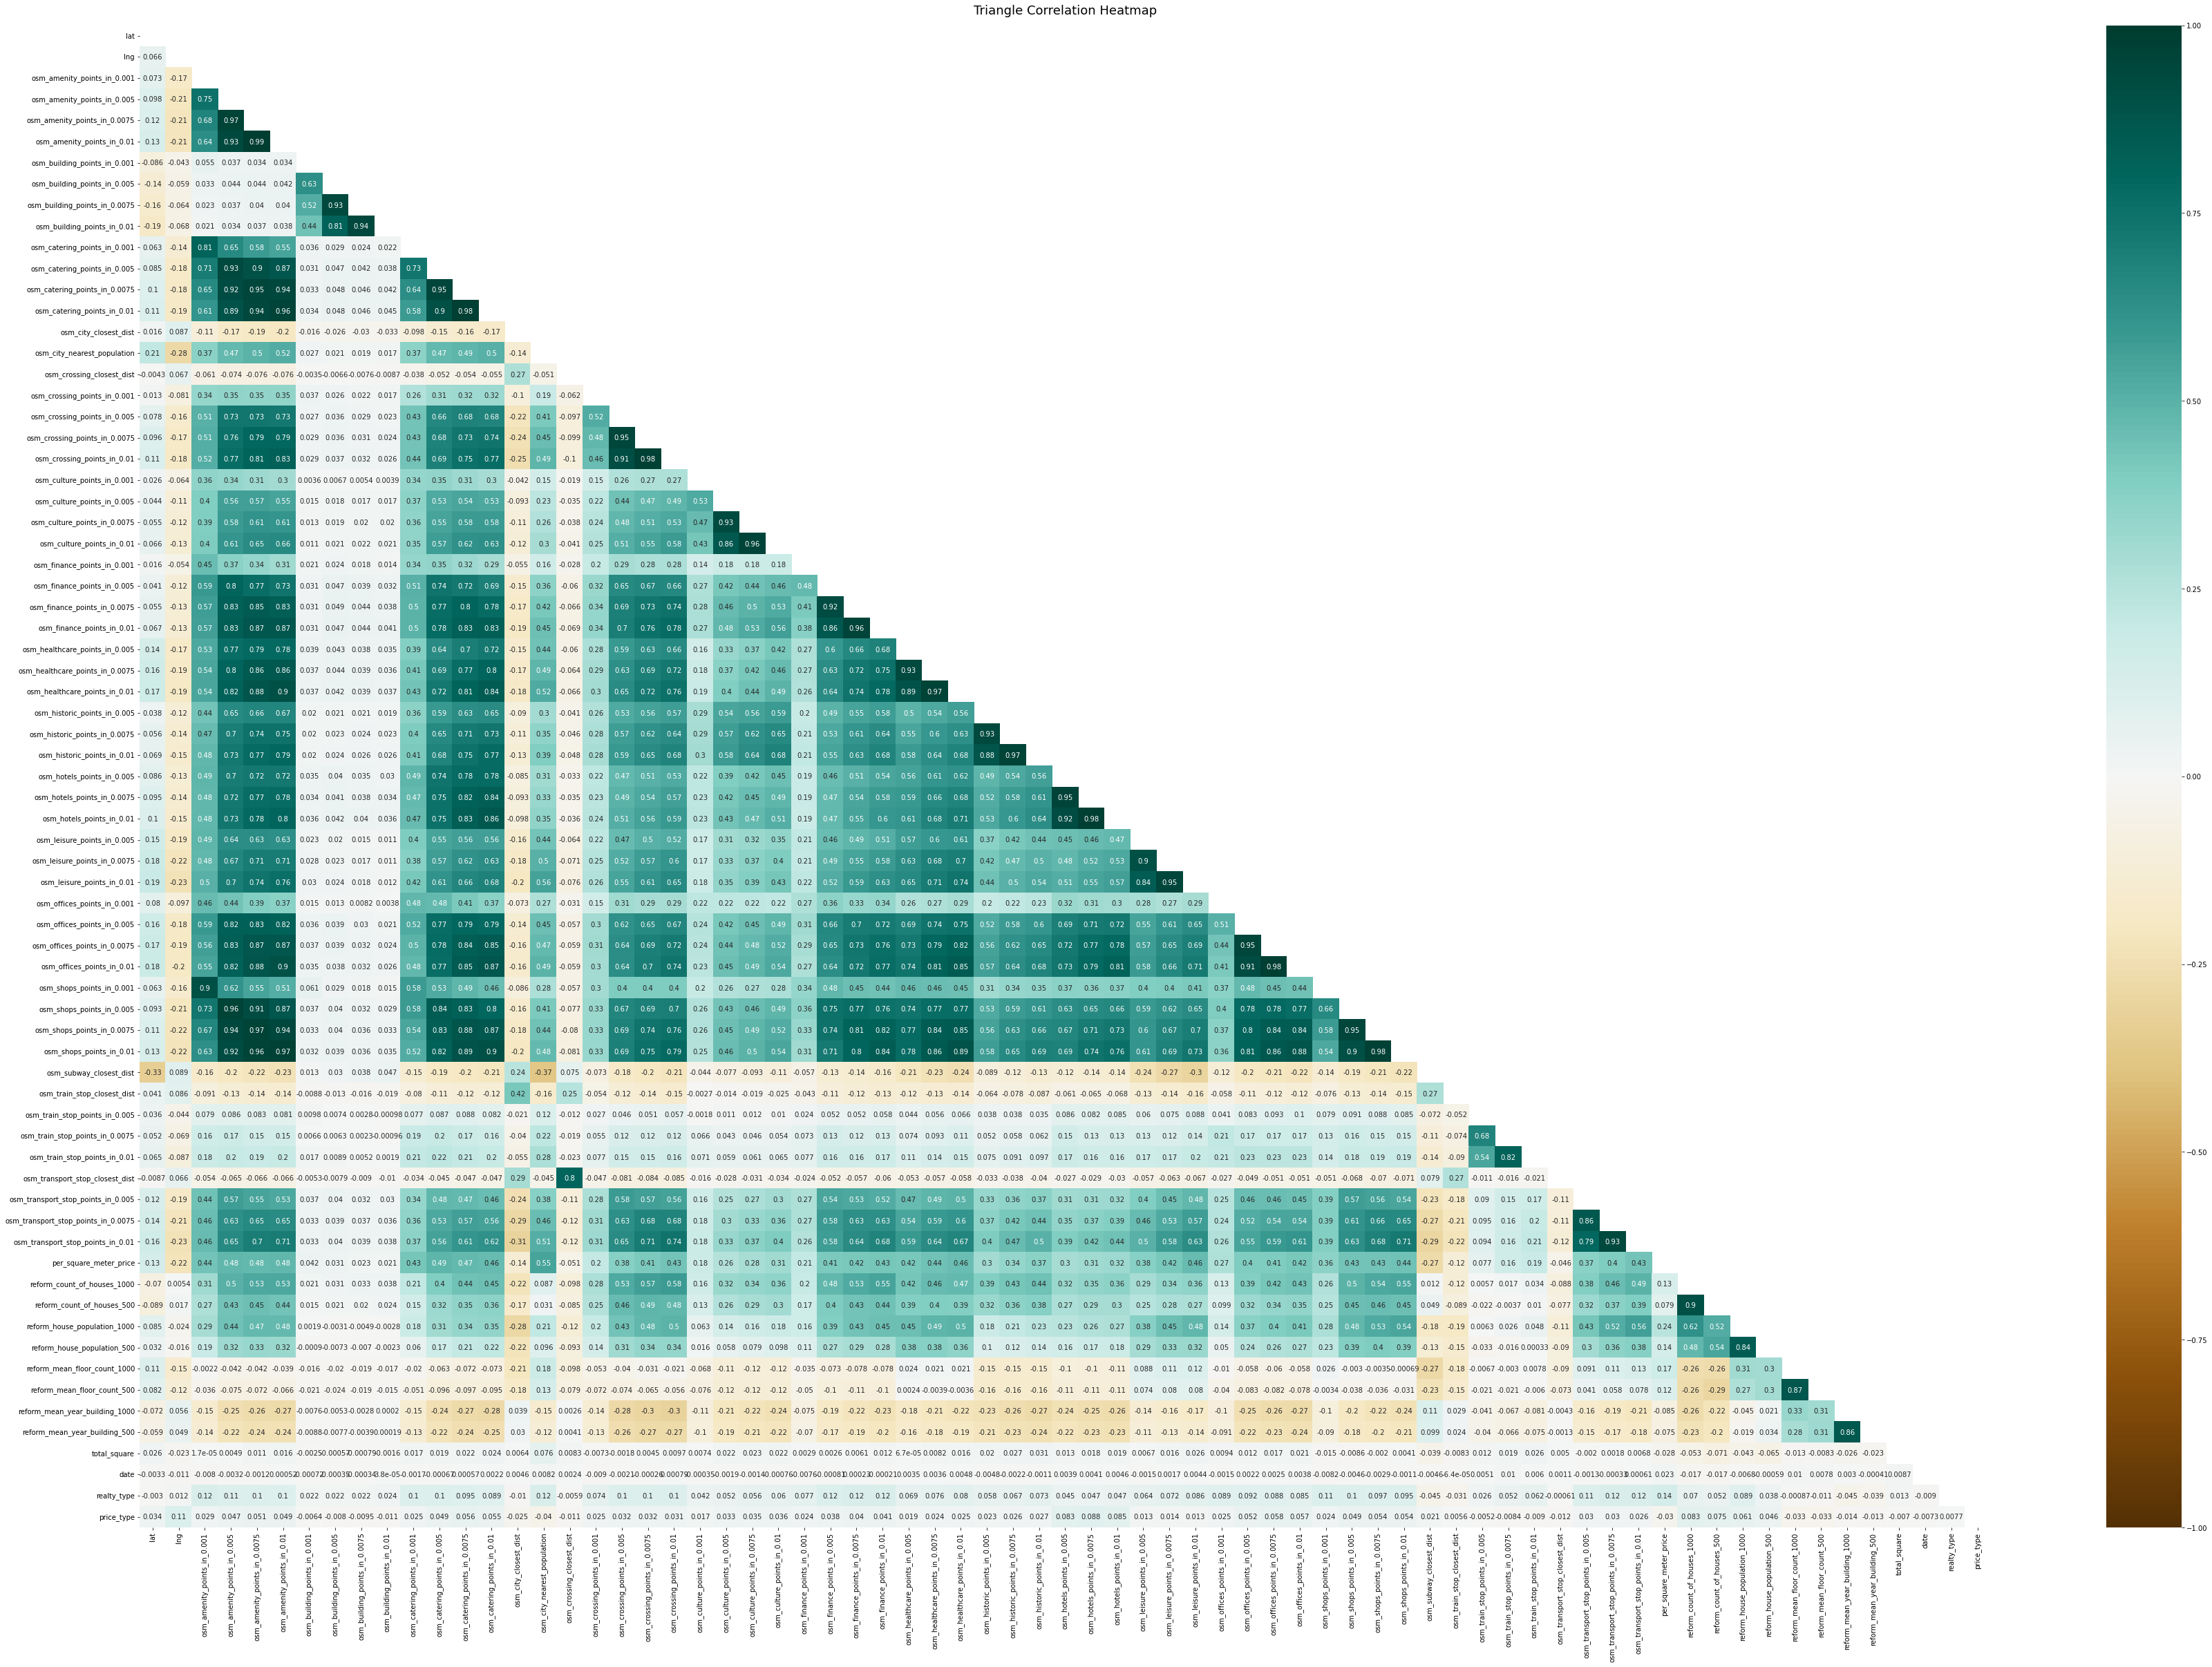

In [19]:
# heat map 

plt.figure(figsize=(60, 40)) 

# маска
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool)) 
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [20]:
# датафрейм, очищенный от мальтиколлинеарности (threshold = 0.8)
df_trim = trimm_correlated(df, 0.8)

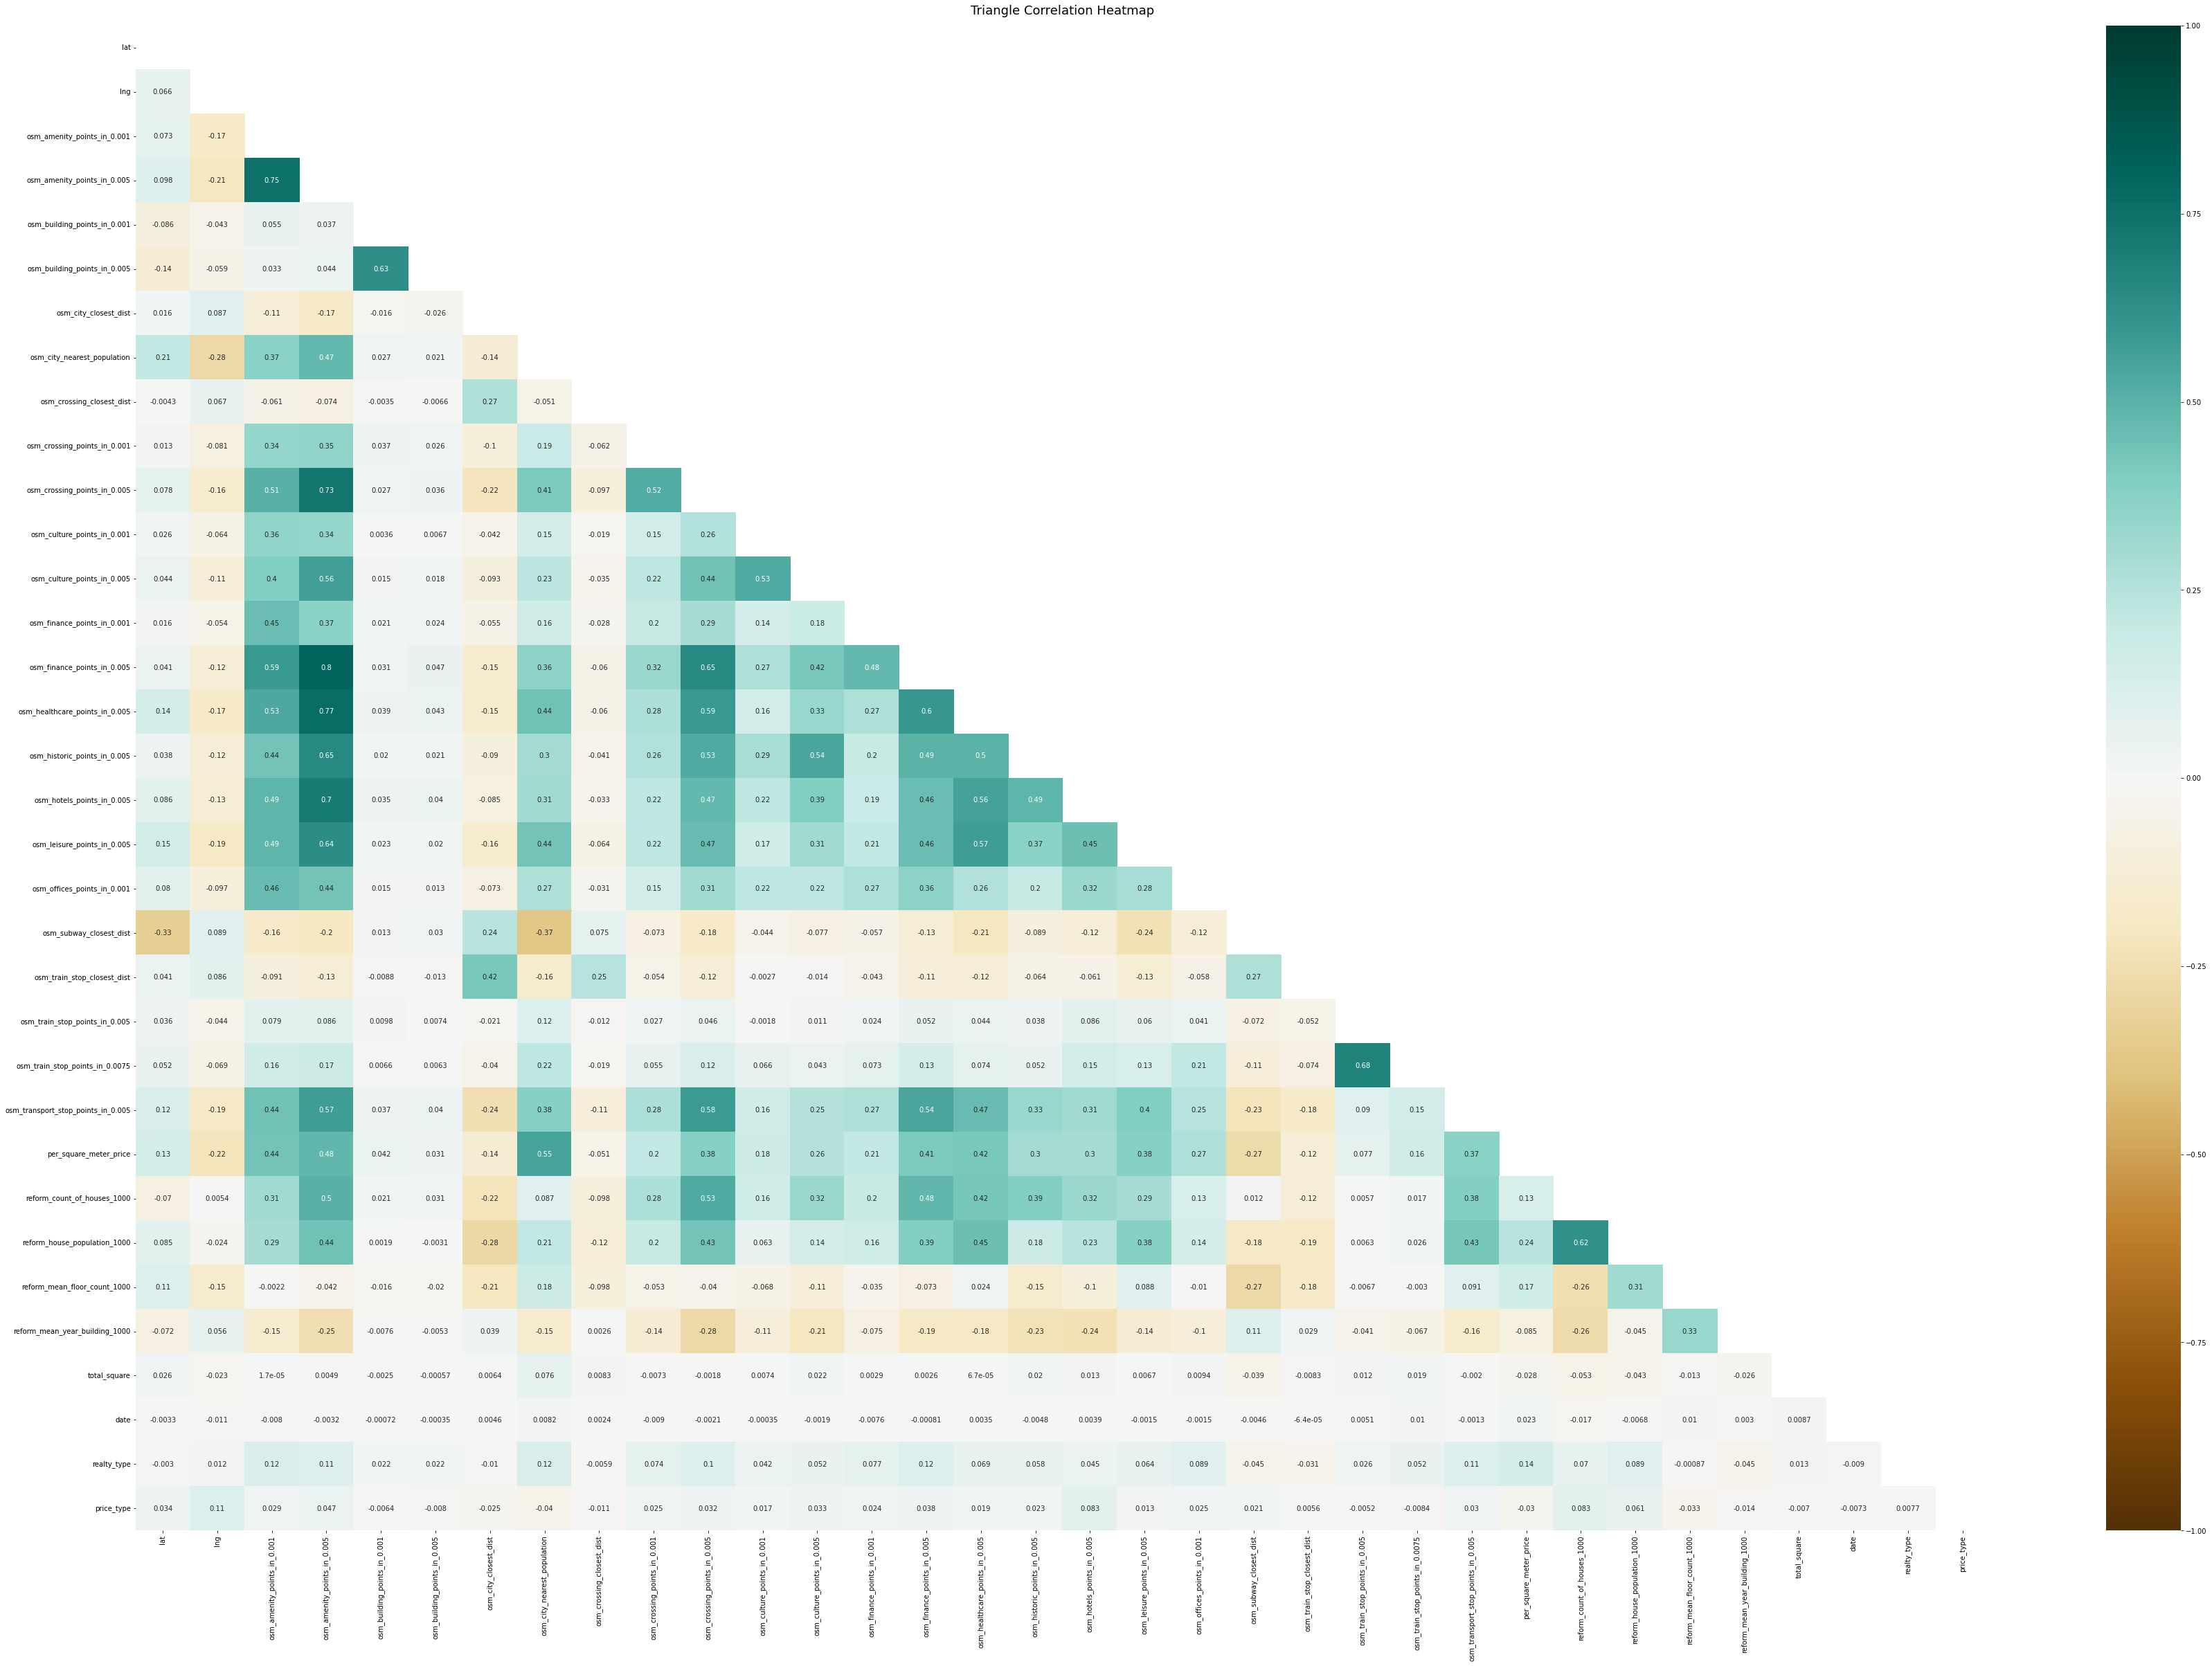

In [21]:
# heat map 

plt.figure(figsize=(60, 40)) 

# маска
mask = np.triu(np.ones_like(df_trim.corr(), dtype=np.bool)) 
heatmap = sns.heatmap(df_trim.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [29]:
# объединим числовые и категориальные признаки
df_sum = pd.concat([df.select_dtypes(include='object'), df_trim], sort = False, axis = 1)

In [30]:
df_sum.shape

(279792, 40)

In [31]:
df_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279792 entries, 0 to 279791
Data columns (total 40 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   city                                279792 non-null  object 
 1   floor                               103555 non-null  object 
 2   id                                  279792 non-null  object 
 3   osm_city_nearest_name               279792 non-null  object 
 4   region                              279792 non-null  object 
 5   street                              278186 non-null  object 
 6   lat                                 279792 non-null  float64
 7   lng                                 279792 non-null  float64
 8   osm_amenity_points_in_0.001         279792 non-null  int64  
 9   osm_amenity_points_in_0.005         279792 non-null  int64  
 10  osm_building_points_in_0.001        279792 non-null  int64  
 11  osm_building_points_in_0.0

In [32]:
pivot(df_sum)

,unique,null,types
price_type,2,0,int64
realty_type,3,0,int64
osm_finance_points_in_0.001,7,0,int64
osm_offices_points_in_0.001,13,0,int64
osm_culture_points_in_0.001,16,0,int64
osm_crossing_points_in_0.001,17,0,int64
osm_train_stop_points_in_0.005,19,0,int64
osm_train_stop_points_in_0.0075,24,0,int64
osm_building_points_in_0.001,25,0,int64
osm_finance_points_in_0.005,29,0,int64


In [33]:
# заменим все пропущенные значения для числовых колонок
my_fillna(df_sum, 'reform_mean_year_building_1000', 1965) 
my_fillna(df_sum, 'reform_mean_floor_count_1000', 2) 
my_fillna(df_sum, 'reform_house_population_1000', 10) 
my_fillna(df_sum, 'osm_city_nearest_population', 2000) 

0

In [34]:
df_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279792 entries, 0 to 279791
Data columns (total 40 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   city                                279792 non-null  object 
 1   floor                               103555 non-null  object 
 2   id                                  279792 non-null  object 
 3   osm_city_nearest_name               279792 non-null  object 
 4   region                              279792 non-null  object 
 5   street                              278186 non-null  object 
 6   lat                                 279792 non-null  float64
 7   lng                                 279792 non-null  float64
 8   osm_amenity_points_in_0.001         279792 non-null  int64  
 9   osm_amenity_points_in_0.005         279792 non-null  int64  
 10  osm_building_points_in_0.001        279792 non-null  int64  
 11  osm_building_points_in_0.0

In [35]:
df_sum.select_dtypes(include='object').head()

,city,floor,id,osm_city_nearest_name,region,street
0,Пермь,NaN,COL_0,Пермь,Пермский край,S27289
1,Шатура,NaN,COL_1,Орехово-Зуево,Московская область,S17052
2,Ярославль,NaN,COL_2,Ярославль,Ярославская область,S16913
3,Новокузнецк,NaN,COL_3,Новокузнецк,Кемеровская область,S10148
4,Москва,NaN,COL_4,Химки,Москва,S1338


In [37]:
# закодирую несоклько категориальных переменных
freq_enc('region', df_sum)
freq_enc('city', df_sum)
freq_enc('osm_city_nearest_name', df_sum)

In [38]:
df_sum.shape

(279792, 43)

In [39]:
df_sum.select_dtypes(include=['int','float']).columns

Index(['lat', 'lng', 'osm_amenity_points_in_0.001',
       'osm_amenity_points_in_0.005', 'osm_building_points_in_0.001',
       'osm_building_points_in_0.005', 'osm_city_closest_dist',
       'osm_city_nearest_population', 'osm_crossing_closest_dist',
       'osm_crossing_points_in_0.001', 'osm_crossing_points_in_0.005',
       'osm_culture_points_in_0.001', 'osm_culture_points_in_0.005',
       'osm_finance_points_in_0.001', 'osm_finance_points_in_0.005',
       'osm_healthcare_points_in_0.005', 'osm_historic_points_in_0.005',
       'osm_hotels_points_in_0.005', 'osm_leisure_points_in_0.005',
       'osm_offices_points_in_0.001', 'osm_subway_closest_dist',
       'osm_train_stop_closest_dist', 'osm_train_stop_points_in_0.005',
       'osm_train_stop_points_in_0.0075', 'osm_transport_stop_points_in_0.005',
       'per_square_meter_price', 'reform_count_of_houses_1000',
       'reform_house_population_1000', 'reform_mean_floor_count_1000',
       'reform_mean_year_building_1000', 'tot

In [40]:
num_cols= ['lat', 'lng', 'osm_amenity_points_in_0.001',
       'osm_amenity_points_in_0.005', 'osm_building_points_in_0.001',
       'osm_building_points_in_0.005', 'osm_city_closest_dist',
       'osm_city_nearest_population', 'osm_crossing_closest_dist',
       'osm_crossing_points_in_0.001', 'osm_crossing_points_in_0.005',
       'osm_culture_points_in_0.001', 'osm_culture_points_in_0.005',
       'osm_finance_points_in_0.001', 'osm_finance_points_in_0.005',
       'osm_healthcare_points_in_0.005', 'osm_historic_points_in_0.005',
       'osm_hotels_points_in_0.005', 'osm_leisure_points_in_0.005',
       'osm_offices_points_in_0.001', 'osm_subway_closest_dist',
       'osm_train_stop_closest_dist', 'osm_train_stop_points_in_0.005',
       'osm_train_stop_points_in_0.0075', 'osm_transport_stop_points_in_0.005',
       'reform_count_of_houses_1000',
       'reform_house_population_1000', 'reform_mean_floor_count_1000',
       'reform_mean_year_building_1000', 'total_square', 'date', 'realty_type',
       'price_type']

In [41]:
FE_cols = ['FE_region', 'FE_city', 'FE_osm_city_nearest_name']

In [42]:
target_cols = 'per_square_meter_price'

In [43]:
cat_cols=['city', 'osm_city_nearest_name', 'region']

### catboost на всей выборке df_sum

In [44]:
X = df_sum[num_cols + cat_cols].drop('date', axis=1, inplace=False)
y = df_sum[target_cols]

Learning rate set to 0.094255
0:	learn: 163903.8608641	total: 178ms	remaining: 2m 57s
1:	learn: 156863.9984682	total: 361ms	remaining: 2m 59s
2:	learn: 150783.1409797	total: 512ms	remaining: 2m 50s
3:	learn: 145580.7177528	total: 645ms	remaining: 2m 40s
4:	learn: 140793.2141522	total: 811ms	remaining: 2m 41s
5:	learn: 136905.1144006	total: 990ms	remaining: 2m 44s
6:	learn: 133343.2503790	total: 1.16s	remaining: 2m 44s
7:	learn: 130169.6177279	total: 1.32s	remaining: 2m 43s
8:	learn: 127557.7213930	total: 1.46s	remaining: 2m 41s
9:	learn: 125452.9896979	total: 1.64s	remaining: 2m 41s
10:	learn: 123367.7475775	total: 1.8s	remaining: 2m 41s
11:	learn: 121531.7948564	total: 1.95s	remaining: 2m 40s
12:	learn: 119963.3960082	total: 2.11s	remaining: 2m 40s
13:	learn: 118601.8680320	total: 2.28s	remaining: 2m 40s
14:	learn: 117333.1728448	total: 2.45s	remaining: 2m 40s
15:	learn: 116309.3151358	total: 2.59s	remaining: 2m 39s
16:	learn: 115445.2842335	total: 2.75s	remaining: 2m 38s
17:	learn: 1

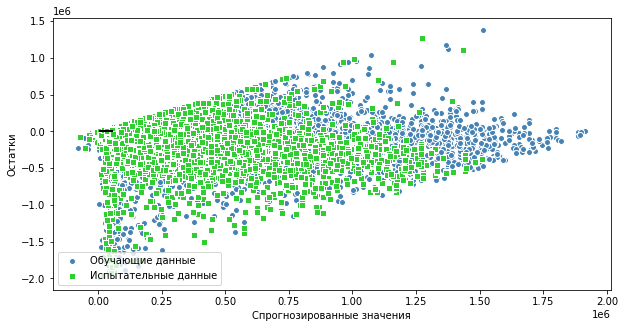

In [47]:
cb_pipeline(X, y, cat_cols)

### catboost на выборке price_type =1

In [48]:
X = df_sum.query('price_type == 1')[num_cols + cat_cols].drop(['price_type','date'], axis=1, inplace=False)
y = df_sum.query('price_type == 1')[target_cols]

Learning rate set to 0.049069
0:	learn: 88639.2040360	total: 9.34ms	remaining: 9.33s
1:	learn: 87579.9680265	total: 18.3ms	remaining: 9.11s
2:	learn: 86505.9353138	total: 26.6ms	remaining: 8.85s
3:	learn: 85497.4400982	total: 35.1ms	remaining: 8.75s
4:	learn: 84510.9709445	total: 43.4ms	remaining: 8.64s
5:	learn: 83668.6089646	total: 51.8ms	remaining: 8.57s
6:	learn: 82797.1597789	total: 60.5ms	remaining: 8.58s
7:	learn: 81943.2877530	total: 68.6ms	remaining: 8.51s
8:	learn: 81046.1211051	total: 76.7ms	remaining: 8.44s
9:	learn: 80213.2047040	total: 84.8ms	remaining: 8.39s
10:	learn: 79477.2441872	total: 93.8ms	remaining: 8.43s
11:	learn: 78700.3297054	total: 102ms	remaining: 8.44s
12:	learn: 78108.1002465	total: 111ms	remaining: 8.45s
13:	learn: 77449.4197835	total: 120ms	remaining: 8.43s
14:	learn: 76791.8756496	total: 128ms	remaining: 8.39s
15:	learn: 76250.8560723	total: 136ms	remaining: 8.35s
16:	learn: 75711.2575347	total: 144ms	remaining: 8.34s
17:	learn: 75040.7470907	total: 15

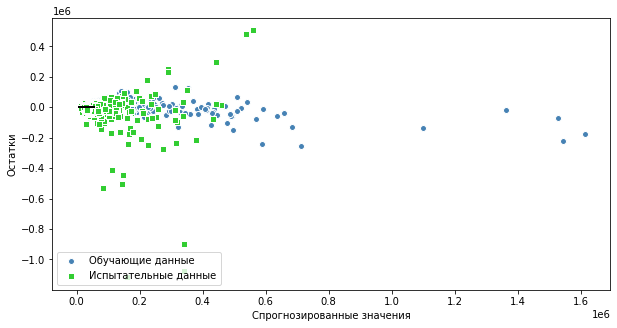

In [49]:
cb_pipeline(X, y, cat_cols)

### Простая NN

In [53]:
X = normalize(df_sum[num_cols + FE_cols].values)
y = df_sum[target_cols]
X.shape, y.shape

((279792, 36), (279792,))

In [54]:
np.random.seed(0)

In [55]:
features_train, features_test, target_train, target_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

In [56]:
features_train.shape, features_test.shape

((209844, 36), (69948, 36))

In [57]:
network = models.Sequential()

In [58]:
network.add(layers.Dense(
    units=50,
    activation='relu',
    input_shape=(features_train.shape[1],)
))

In [59]:
network.add(layers.Dense(units=32,activation='relu'))

In [60]:
network.add(layers.Dense(units=1))

In [61]:
network.compile(
    loss='binary_crossentropy',
    optimizer='RMSprop',
    metrics='mse'
)

In [62]:
history = network.fit(
    features_train,
    target_train,
    epochs=10,
    verbose=1,
    batch_size=4,
    validation_data=(features_test,target_test)
)

Epoch 1/10
52461/52461 [==============================] - 176s 3ms/step - loss: -1680620.1250 - mse: 41830674432.0000 - val_loss: -1678579.1250 - val_mse: 41484169216.0000
Epoch 2/10
52461/52461 [==============================] - 191s 4ms/step - loss: -1680977.5000 - mse: 41830944768.0000 - val_loss: -1678579.1250 - val_mse: 41484169216.0000
Epoch 3/10
52461/52461 [==============================] - 192s 4ms/step - loss: -1680976.0000 - mse: 41830731776.0000 - val_loss: -1678579.1250 - val_mse: 41484169216.0000
Epoch 4/10
52461/52461 [==============================] - 191s 4ms/step - loss: -1680977.7500 - mse: 41830866944.0000 - val_loss: -1678579.1250 - val_mse: 41484169216.0000
Epoch 5/10
52461/52461 [==============================] - 174s 3ms/step - loss: -1680977.6250 - mse: 41830862848.0000 - val_loss: -1678579.1250 - val_mse: 41484169216.0000
Epoch 6/10
52461/52461 [==============================] - 173s 3ms/step - loss: -1680975.8750 - mse: 41830846464.0000 - val_loss: -1678579.1

In [63]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

In [64]:
epoch_count = range(1, len(training_loss)+1)

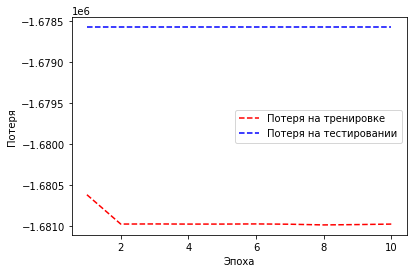

In [66]:
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b--')
plt.legend(['Потеря на тренировке',
            'Потеря на тестировании'])
plt.xlabel ('Эпоха')
plt.ylabel('Потеря')
plt.show()